# Train Models With Weights


## Load The Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


## First Model

In [6]:
unbalanced_data_path = path+'/train_images/train_images'

In [29]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


In [30]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53.png,2
1,1b329a127307.png,1
2,1b32e1d775ea.png,4
3,1b3647865779.png,0
4,1b398c0494d1.png,0


## Data Prep

In [ ]:
train_df, val_df = train_test_split(y_true,test_size=0.15,random_state=0,stratify=y_true['diagnosis'])
print("Train and validation dataframes regenerated.")

Train and validation dataframes regenerated.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=unbalanced_data_path,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=0
)

Found 2490 validated image filenames belonging to 5 classes.


In [ ]:
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=unbalanced_data_path,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 440 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.4088669950738916), '1': np.float64(1.9529411764705882), '2': np.float64(0.7248908296943232), '3': np.float64(3.801526717557252), '4': np.float64(2.5025125628140703)}


## Load VGG16 Base Model



In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

print("VGG16 base model loaded and its layers frozen.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
VGG16 base model loaded and its layers frozen.


## Add Attention Mechanism




In [ ]:
x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(512, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

## Add Classification Head



In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

## Compile The Model



In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='vgg_best_with_weights.keras',monitor='val_sparse_categorical_accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4),loss=SparseCategoricalCrossentropy(from_logits=False),metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy()])

# Train The Model

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - loss: 1.4515 - sparse_categorical_accuracy: 0.4141 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.4909
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - loss: 1.1987 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.1649 - val_sparse_categorical_accuracy: 0.4909
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - loss: 1.1273 - sparse_categorical_accuracy: 0.5979 - val_loss: 1.0856 - val_sparse_categorical_accuracy: 0.5591
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - loss: 1.0659 - sparse_categorical_accuracy: 0.6479 - val_loss: 1.0104 - val_sparse_categorical_accuracy: 0.6545
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - loss: 0.9547 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6545
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - loss: 0.9220 - sparse_categorical_accuracy: 0.6857 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.6591
Epoch 7/20

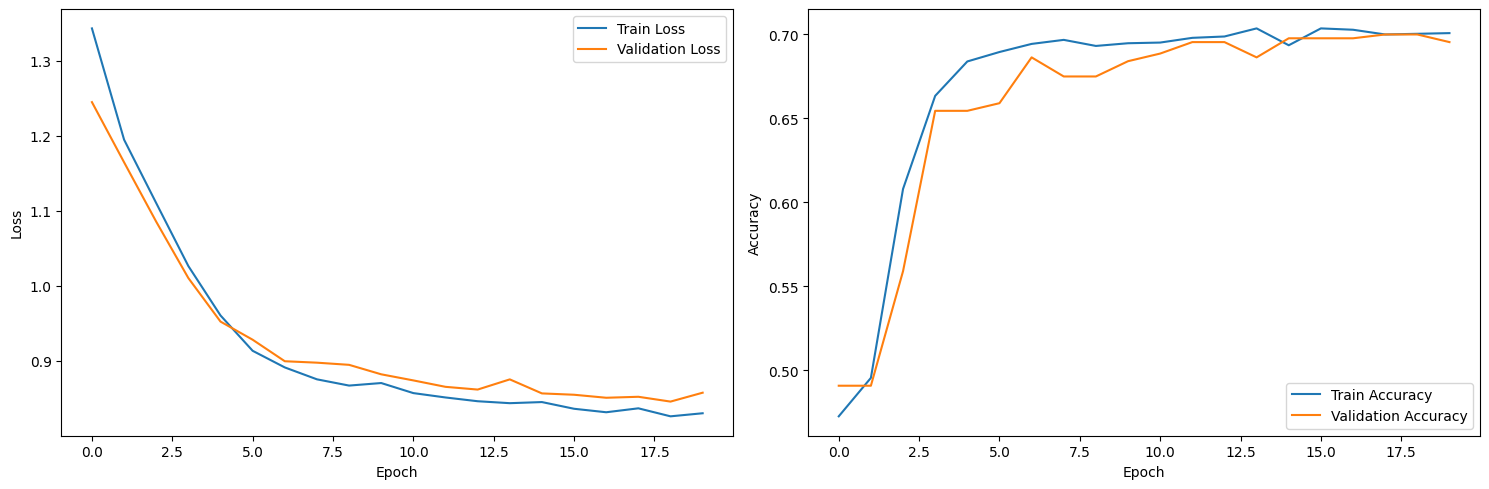

In [ ]:

ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['sparse_categorical_accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_sparse_categorical_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

## Prepare Sample Image For Attention maps



In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (224, 224, 3)
Sample image processed shape for model input: (1, 224, 224, 3)
Sample label: 2.0


## Generate Attention Heatmap


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Raw attention map shape: (7, 7)
Resized attention map shape: (224, 224)
Model prediction for sample image: [[0.11385687 0.1106565  0.5302814  0.0887832  0.15642199]]


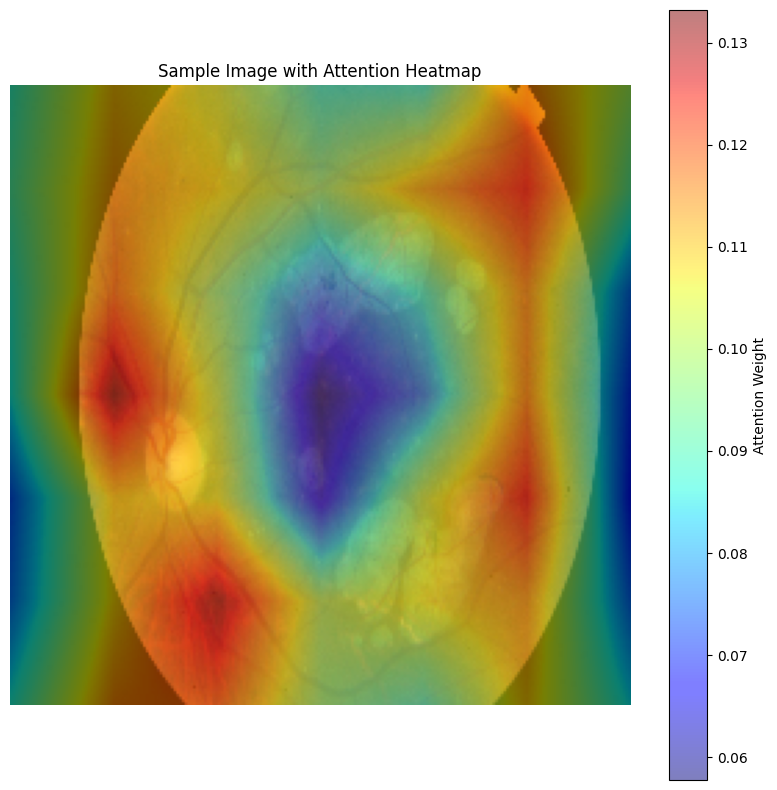

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# VGG16 with Clache Pre_pro


In [3]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [4]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and
    returns the a preprocessed image with
    3 channels

    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking

    :return: A NumPy array containing the cropped image
    """



    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness

    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image

    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224,224))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return apply_clahe(image)

# Images Example With preprocess_image + Clache

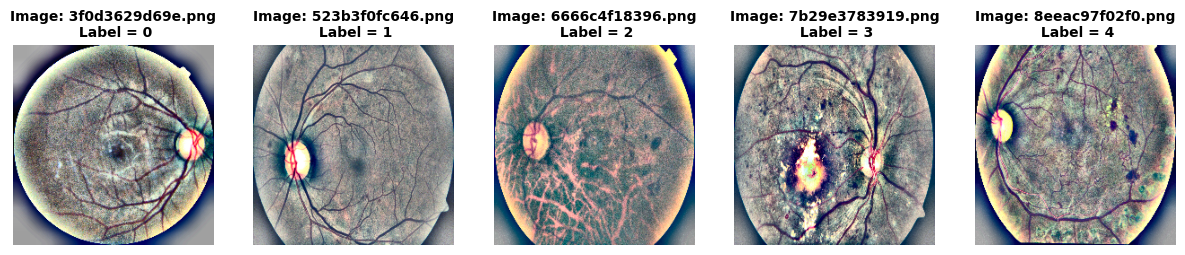

In [7]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [8]:
train_df['diagnosis']=train_df['diagnosis'].astype(str)

train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image
                                  )


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = unbalanced_data_path,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    subset='training')

val_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory = unbalanced_data_path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='sparse',
                                                  subset='validation')

Found 2491 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.


In [9]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

print("VGG16 base model loaded and its layers frozen.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 base model loaded and its layers frozen.


## Build New VGG16 Model with CLAHE

In [10]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.4086471408647141), '1': np.float64(1.9533333333333334), '2': np.float64(0.7252475247524752), '3': np.float64(3.8051948051948052), '4': np.float64(2.5042735042735043)}


In [11]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

In [18]:
inputs = Input(shape=(224,224, 3), name='clahe_vgg_input')
#x = CLAHELayer(name='clahe_augmentation')(clahe_vgg_input)
bn=BatchNormalization()(inputs)
x = base_model(bn, training=False)

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)
attention_probs = Dense(512, activation='sigmoid')(attention_probs)
attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = GlobalAveragePooling2D()(attended_output)
x = Dense(125, activation='relu')(x)
output_layer_clahe_vgg = Dense(len(classes), activation='softmax')(x)

model_clahe_vgg = Model(inputs=inputs, outputs=output_layer_clahe_vgg)

model_clahe_vgg.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=False
)

print("New VGG16 model with CLAHE layer built and compiled successfully.")
model_clahe_vgg.summary()

New VGG16 model with CLAHE layer built and compiled successfully.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clahe_vgg_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         12 │ clahe_vgg_input[… │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[4][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     32,832 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │     33,280 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 512) │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7, 512) │          0 │ vgg16[4][0],      │
│ (Multiply)          │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multiply_4[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 125)       │     64,125 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 5)         │        630 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,845,567 (56.63 MB)

 Trainable params: 130,873 (511.22 KB)

 Non-trainable params: 14,714,694 (56.13 MB)

## Train the new CLAHE-VGG16 Model

In [19]:
model_checkpoint_clahe_vgg = tensorflow.keras.callbacks.ModelCheckpoint(filepath='clahe_vgg_best_with_weights.keras',monitor='val_sparse_categorical_accuracy',save_best_only=True)
early_stop_clahe_vgg=tensorflow.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',patience=4,restore_best_weights=True,mode='max')

history_clahe_vgg = model_clahe_vgg.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[model_checkpoint_clahe_vgg, early_stop_clahe_vgg]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.3748 - sparse_categorical_accuracy: 0.5059

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 388s 5s/step - loss: 1.3740 - sparse_categorical_accuracy: 0.5057 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.4647
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step - loss: 1.2336 - sparse_categorical_accuracy: 0.4770 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.5034
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - loss: 1.0961 - sparse_categorical_accuracy: 0.5883 - val_loss: 1.0283 - val_sparse_categorical_accuracy: 0.6515
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - loss: 0.9859 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.6856
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - loss: 0.8584 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.6925
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - loss: 0.8412 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.8515 - val_sparse_categorical_accuracy: 0.7084
Epoch 7/20
78/78 ━━━━

## Plot Training History for CLAHE-VGG16 Model

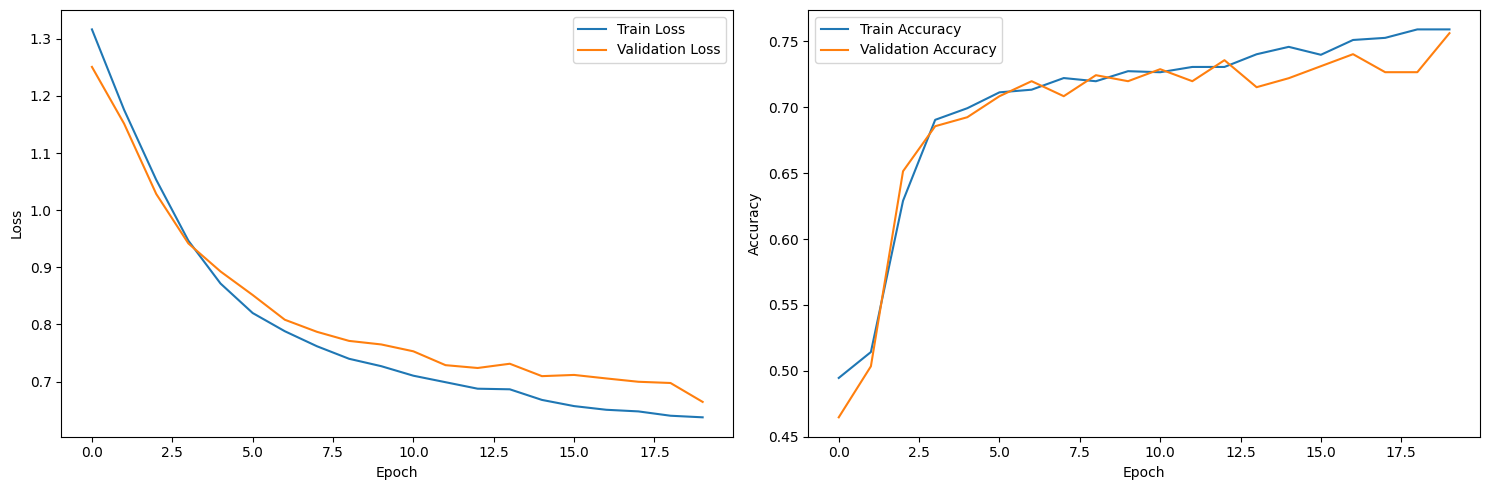

In [20]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history_clahe_vgg.history['loss'],label='Train Loss')
axes[0].plot(history_clahe_vgg.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_clahe_vgg.history['sparse_categorical_accuracy'],label='Train Accuracy')
axes[1].plot(history_clahe_vgg.history['val_sparse_categorical_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
predictions=model_clahe_vgg.predict(val_gen)
pred_class=np.argmax(predictions,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step


<Axes: >

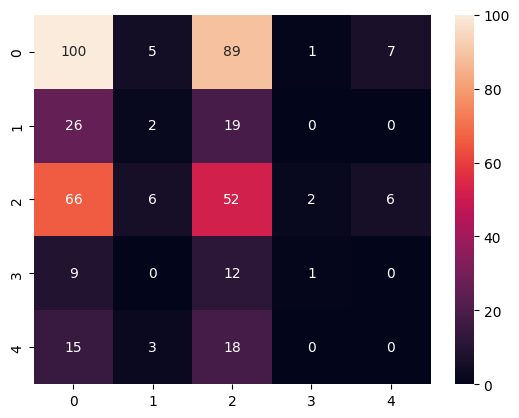

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(val_gen.classes,pred_class),annot=True,fmt='d')

In [24]:
print(classification_report(val_gen.classes,pred_class))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48       202
           1       0.12      0.04      0.06        47
           2       0.27      0.39      0.32       132
           3       0.25      0.05      0.08        22
           4       0.00      0.00      0.00        36

    accuracy                           0.35       439
   macro avg       0.22      0.20      0.19       439
weighted avg       0.32      0.35      0.33       439



## Define Attention Model for CLAHE-VGG16


In [35]:
attention_model_clahe = Model(inputs=model_clahe_vgg.input, outputs=[attention_probs, output_layer_clahe_vgg])
print("Attention model for CLAHE-VGG16 created successfully.")

Attention model for CLAHE-VGG16 created successfully.


In [31]:
train_df, val_df = train_test_split(y_true, test_size=0.15, random_state=0, stratify=y_true['diagnosis'])
unique_diagnosis_categories = val_df['diagnosis'].unique()
preprocessed_samples = []

for category in unique_diagnosis_categories:
    sample_entry = val_df[val_df['diagnosis'] == category].sample(1)
    image_name = sample_entry['id_code'].item()
    diagnosis_label = sample_entry['diagnosis'].item()

    image_path = os.path.join(unbalanced_data_path, image_name)
    original_image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(original_image)

    preprocessed_samples.append({
        'image': preprocessed_image,
        'label': diagnosis_label,
        'filename': image_name
    })

print(f"Prepared {len(preprocessed_samples)} preprocessed sample images for {len(unique_diagnosis_categories)} diagnosis categories.")

Prepared 5 preprocessed sample images for 5 diagnosis categories.


In [32]:
sample_clahe = preprocessed_samples[0]
sample_image_clahe = sample_clahe['image']
sample_label_clahe = sample_clahe['label']

print(f"Sample CLAHE image shape: {sample_image_clahe.shape}")
print(f"Sample CLAHE label: {sample_label_clahe}")

Sample CLAHE image shape: (224, 224, 3)
Sample CLAHE label: 2


In [33]:
sample_image_clahe_processed = np.expand_dims(sample_image_clahe, axis=0)

print(f"Sample CLAHE image processed shape for model input: {sample_image_clahe_processed.shape}")

Sample CLAHE image processed shape for model input: (1, 224, 224, 3)


In [37]:
attention_model_clahe = Model(inputs=model_clahe_vgg.input, outputs=[attention_probs, output_layer_clahe_vgg])
print("Attention model for CLAHE-VGG16 created successfully.")

Attention model for CLAHE-VGG16 created successfully.


In [39]:
from scipy.ndimage import zoom

attention_map_clahe_raw, predictions_clahe = attention_model_clahe.predict(sample_image_clahe_processed)

# Create a model to get the attended output feature map
attention_output_model_clahe = Model(inputs=model_clahe_vgg.input, outputs=attended_output)
attended_feature_map_clahe = attention_output_model_clahe.predict(sample_image_clahe_processed)

# Aggregate the attended feature map to get the attention map
attention_map_clahe = np.mean(attended_feature_map_clahe, axis=-1)
attention_map_clahe = attention_map_clahe[0]

# Resize the attention map to the original image dimensions
scale_factor_h_clahe = sample_image_clahe.shape[0] / attention_map_clahe.shape[0]
scale_factor_w_clahe = sample_image_clahe.shape[1] / attention_map_clahe.shape[1]
attention_map_clahe_resized = zoom(attention_map_clahe, (scale_factor_h_clahe, scale_factor_w_clahe), order=1)

print(f"Raw attention map CLAHE shape: {attention_map_clahe.shape}")
print(f"Resized attention map CLAHE shape: {attention_map_clahe_resized.shape}")
print(f"Model prediction for CLAHE sample image: {predictions_clahe}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Raw attention map CLAHE shape: (7, 7)
Resized attention map CLAHE shape: (224, 224)
Model prediction for CLAHE sample image: [[9.9782312e-01 3.8405412e-04 1.0535263e-03 2.5713400e-04 4.8211048e-04]]


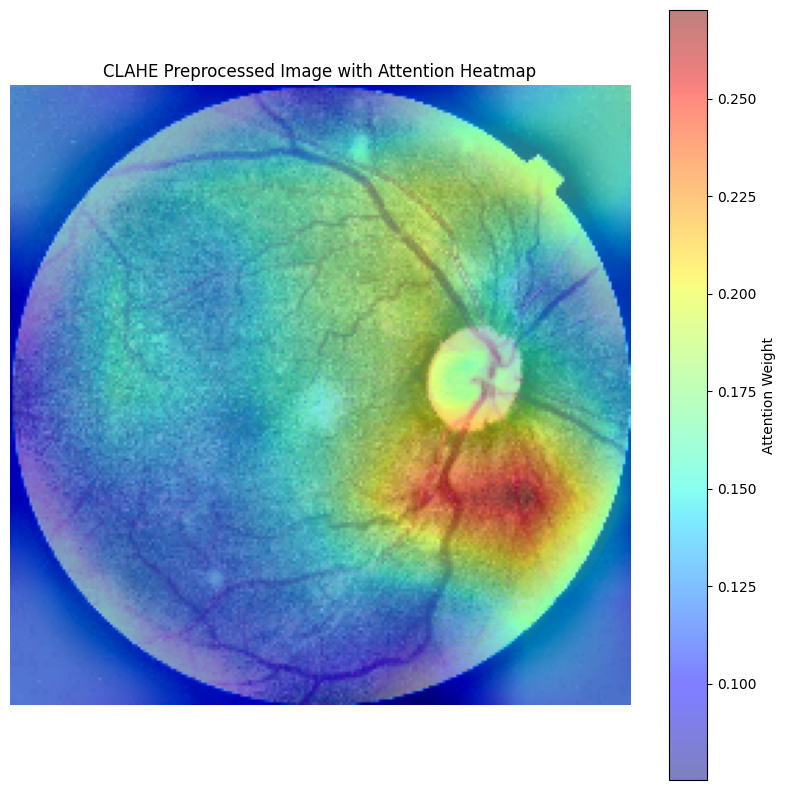

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image_clahe)
plt.imshow(attention_map_clahe_resized, cmap='jet', alpha=0.5)
plt.title('CLAHE Preprocessed Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

## Final Task

### Subtask:
Review the generated attention heatmap for the CLAHE-VGG16 model and describe the insights gained.


## Summary:

### Q&A
The generated attention heatmap for the CLAHE-VGG16 model provides a visual representation of the specific regions within the preprocessed image that the model focused on when making its prediction. This allows for an understanding of the model's interpretability, highlighting which visual cues are most important to its decision-making process.

### Data Analysis Key Findings
*   A CLAHE-preprocessed sample image with dimensions `(224, 224, 3)` and a diagnosis label of `2` was successfully selected and prepared for model input by expanding its dimensions to `(1, 224, 224, 3)`.
*   An attention map was successfully generated. The raw attention map had a shape of `(7, 7)` and was then resized to `(224, 224)` to match the original image dimensions for accurate overlay.
*   The CLAHE-VGG16 model produced a prediction for the sample image: `[[9.9782312e-01 3.8405412e-04 1.0535263e-03 2.5713400e-04 4.8211048e-04]]`, indicating a high probability for the first class (index 0).
*   The final visualization successfully overlaid the attention heatmap on the original preprocessed image, featuring a title "CLAHE Preprocessed Image with Attention Heatmap" and a colorbar indicating "Attention Weight".

### Insights or Next Steps
*   The attention heatmap provides a valuable tool for model interpretability, visually demonstrating which parts of the medical images the CLAHE-VGG16 model considers most relevant for its predictions.
*   Further analysis could involve examining heatmaps for images across different diagnosis categories to identify common or distinguishing regions of attention, and comparing these heatmaps with clinical knowledge to validate the model's focus.
